In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
import seaborn as sns
import pandas as pd
import warnings
import scipy
from dsn.util.systems import Linear2D
from dsn.util.plot_util import plot_opt, assess_constraints, dsn_pairplots
from dsn.util.dsn_util import get_savedir
from tf_util.stat_util import approx_equal
warnings.filterwarnings("ignore")

EPS = 1e-16

In [2]:
# filename info
basedir = '/Users/sbittner/Documents/dsn/dsn/';

start_rs = 2
num_rs = 1

omega = 1

c_init = 0
K = 16
sigma_init = 3.0;

epoch_inds
[   0 1000 2000]
AL_final_its
[None]
0 200


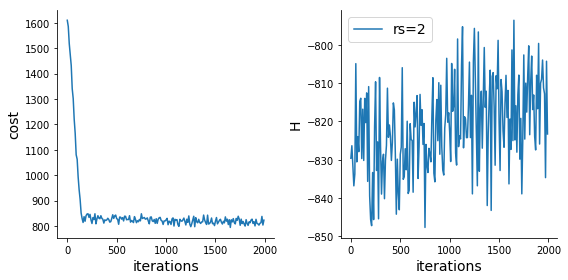

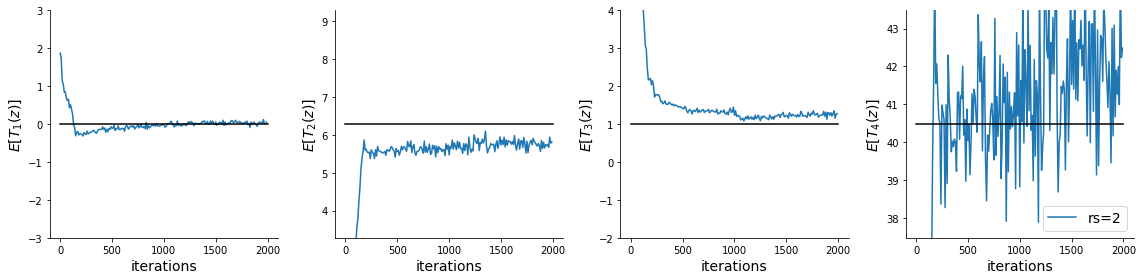

p values
0


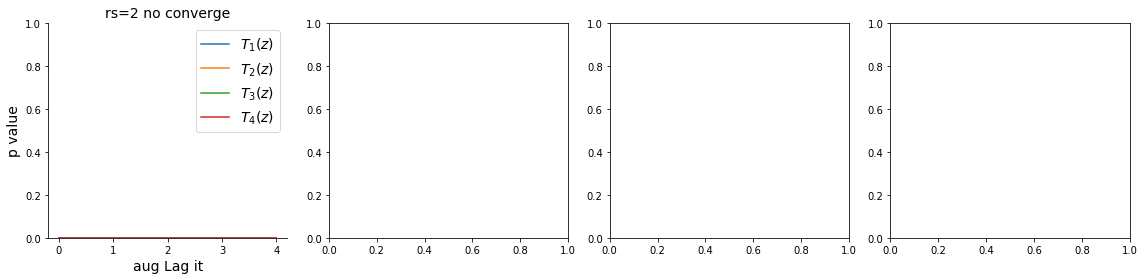

In [3]:
D = 4
tau = 1.0
lr_order = -3
mu = np.array([0.0, 2*np.pi*omega]);
Sigma = np.array([1.0, 1.0]);
behavior = {'type':'oscillation', 'means':mu, 'variances':Sigma};

latent_dynamics = None;
TIF_flow_type = 'PlanarFlow';
mult_and_shift = 'post';
nlayers = 10;

flow_type = "PlanarFlow"
mult_and_shift = "post"
arch_dict = {
    "D": D,
    "K": K,
    "flow_type": flow_type,
    "repeats": nlayers,
    "post_affine": True,
}

fixed_params = {'tau':tau}

system = Linear2D(fixed_params, behavior);

dir_str = 'Linear2D/'

fnames = [];
legendstrs = [];
for rs in range(start_rs, start_rs+num_rs):
    savedir = basedir + get_savedir(system, arch_dict, sigma_init, lr_order, \
                                    c_init, rs, dir_str)
    fname = savedir + 'opt_info.npz';
    fnames.append(fname);
    legendstr = 'rs=%d' % rs;
    legendstrs.append(legendstr);
    
    if (rs==start_rs):
        npzfile = np.load(fnames[0]);
        mu = npzfile['mu'];
        check_rate = npzfile['check_rate'];
        epoch_inds = npzfile['epoch_inds']
        last_ind = npzfile['it']//check_rate;
        nits = npzfile['costs'].shape[0];
        k_max = len(epoch_inds)
        iterations = np.arange(0, check_rate*nits, check_rate);
        npz_behavior = npzfile['behavior'][()]
        # check that behavior is right
        #TODO fixed params assert(npz_behavior['tau'] == behavior['tau'])
        assert(approx_equal(npz_behavior['means'], behavior['means'], EPS))
        assert(approx_equal(npz_behavior['variances'], behavior['variances'], EPS))
    
figs, AL_final_its, p_values = plot_opt(fnames, legendstrs, plotR2=False, frac_samps=0.5);

In [4]:
#pfname = 'images/linear2D_DSN_Z.png'
#lims = [-15, 15]
lims = None
dists = dsn_pairplots(fnames, 'Zs', system, system.D, 'identity', 'log_q_z', \
             [], AL_final_its, xlims=lims, ylims=lims, tri=True, \
             fontsize=25);

 has not converged so not plotting.


In [5]:
from matplotlib import animation

fname = fnames[0]
npzfile = np.load(fname)
Zs = npzfile['Zs']
log_q_zs = npzfile['log_q_zs']
Cs = npzfile['Cs']
alphas = npzfile['alphas']
dist_label_strs = system.z_labels

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)

In [10]:
print(Cs.shape)
np.argmax(Cs, 2)

(201, 1000, 16)


array([[ 6,  9,  3, ...,  7, 14,  1],
       [ 1,  7,  7, ...,  3,  7, 14],
       [ 8, 12, 12, ..., 10,  8, 13],
       ...,
       [ 4, 15, 10, ..., 10,  2,  0],
       [ 5,  7,  0, ...,  3, 12,  3],
       [ 4,  1, 13, ...,  2,  7,  4]])

In [52]:
def make_training_movie(Zs, log_q_zs, Cs, alphas, dist_label_strs, check_rate, epoch_inds, step):
    cm = plt.get_cmap('gist_rainbow')
    scale = 100
    Cs = np.argmax(Cs, 2)
    def size_renorm(x, scale=30):
        y = (x - np.min(x))
        y = y / np.max(y)
        return scale*y
    
    color = [0.0, 0.3, 0.6]
    M = 100
    fontsize = 20
    N, _, D = Zs.shape
    Zs = np.transpose(Zs, [1, 0, 2])
    fig, axs = plt.subplots(D, D-1, figsize=(10,12))
    scats = []
    for i in range(D-1):
        for j in range(1, D):
            if (D==2):
                ax = plt.gca()
            else:
                ax = axs[i+1,j-1]
            if (j > i):
                s = size_renorm(log_q_zs[i,:M], scale)
                scats.append(ax.scatter(Zs[:M,0,j], Zs[:M,0,i], 
                                        s=s, c=Cs[0,:M], cmap=cm, 
                                        edgecolors="k",
                                        linewidths=0.25,))
                ax.set_xlim([-10, 10])
                ax.set_ylim([-10, 10])
            else:
                ax.axis('off')
            if i == j - 1:
                ax.set_xlabel(dist_label_strs[j], fontsize=fontsize)
                ax.set_ylabel(dist_label_strs[i], fontsize=fontsize)

    bar_ax = plt.subplot(D, 1, 1)
    rects = bar_ax.bar(np.arange(1, K+1), alphas[0], color=cm(np.arange(K)/float(K)))
    
    bar_ax.set_ylim([0, 3.0/K])
    bar_ax.set_xlabel('k')
    bar_ax.set_ylabel(r'$\alpha_k$')
    
    lines = ax.plot([], [], '-', c=color)
    

    def animate(i):
        # we'll step two time-steps per frame.  This leads to nice results.
        i = (step * i) % N
        ind = 0
        for ii in range(D-1):
            for j in range(1, D):
                if (j > ii):
                    s = size_renorm(log_q_zs[i,:M], scale)
                    scat = scats[ind]
                    scat.set_offsets(np.stack((Zs[:M,i,j],Zs[:M,i,ii]), 1))
                    scat.set_array(Cs[i,:M])
                    scat.set_sizes(s)
                    ind += 1
                    
        AL_it = np.sum(epoch_inds < i*check_rate)
        bar_ax.set_title('AL=%d' % AL_it)
        j = 0
        for rect in rects:
            rect.set_height(alphas[i,j])
            j += 1

        fig.canvas.draw()
        return lines + scats

    # instantiate the animator.
    frames = ((N-1)//step)
    anim = animation.FuncAnimation(fig, animate,
                                   frames=frames, interval=30, blit=True)

    print('Making video.')
    anim.save('DSN_training.mp4', writer=writer)
    print('Video complete.')


Making video.
Video complete.


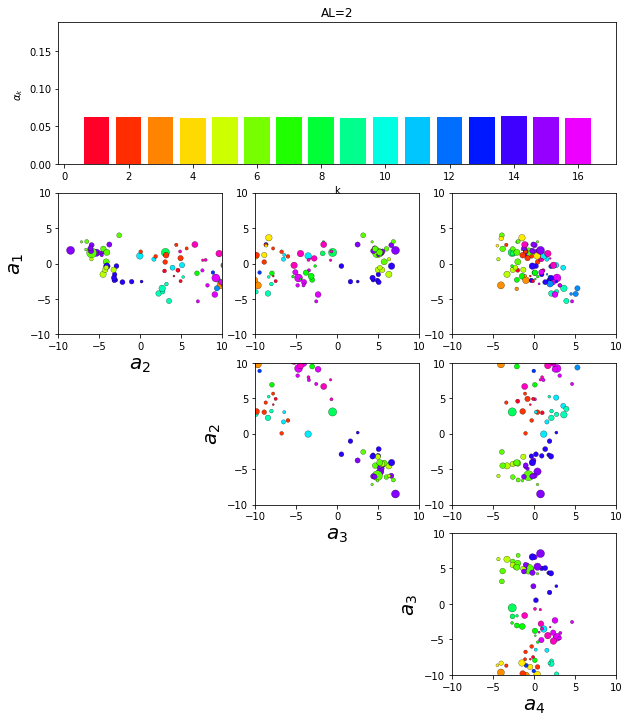

In [53]:
step = 10

make_training_movie(Zs, log_q_zs, Cs, alphas, dist_label_strs, check_rate, epoch_inds, step)

In [47]:
cm = plt.get_cmap('gist_rainbow')
print(cm(0.1))

(1.0, 0.36777954425013254, 0.0, 1.0)
